In [1]:
import harmonica as hm
import matplotlib.pyplot as plt
import numpy as np
import verde as vd
import xarray as xr

import magali as mg

In [2]:
sensor_sample_distance = 5.0  # µm
region = [0, 2000, 0, 2000]  # µm
spacing = 2  # µm

true_inclination = 30
true_declination = 40
true_dispersion_angle = 5


size = 100

directions_inclination, directions_declination = mg.random_directions(
    true_inclination,
    true_declination,
    true_dispersion_angle,
    size=size,
    random_state=5,
)

dipoles_amplitude = abs(np.random.normal(0, 100, size)) * 1.0e-14

dipole_coordinates = (
    np.concatenate([np.random.randint(30, 1970, size), [1250, 1300, 500]]),  # µm
    np.concatenate([np.random.randint(30, 1970, size), [500, 1750, 1000]]),  # µm
    np.concatenate([np.random.randint(-20, -1, size), [-15, -15, -30]]),  # µm
)
dipole_moments = hm.magnetic_angles_to_vec(
    inclination=np.concatenate([directions_inclination, [10, -10, -5]]),
    declination=np.concatenate([directions_declination, [10, 170, 190]]),
    intensity=np.concatenate([dipoles_amplitude, [5e-11, 5e-11, 5e-11]]),
)

data = mg.dipole_bz_grid(
    region, spacing, sensor_sample_distance, dipole_coordinates, dipole_moments
)
data

<xarray.DataArray 'bz' (y: 1001, x: 1001)> Size: 8MB
array([[  5.75579178,   5.80235792,   5.84941598, ...,  11.20841375,
         11.08121811,  10.95627822],
       [  5.79476683,   5.84187452,   5.88948247, ...,  11.32989443,
         11.20112229,  11.07462351],
       [  5.83404969,   5.88170584,   5.92987074, ...,  11.45346706,
         11.32310771,  11.195038  ],
       ...,
       [353.39773091, 375.79989349, 399.42908346, ...,  80.46141253,
         79.04504462,  77.5925126 ],
       [338.14056768, 358.80973759, 380.55188685, ...,  76.55781378,
         75.25274995,  73.91367197],
       [323.29237756, 342.35442734, 362.35356693, ...,  72.90986035,
         71.70538717,  70.46895364]])
Coordinates:
  * x        (x) float64 8kB 0.0 2.0 4.0 6.0 ... 1.996e+03 1.998e+03 2e+03
  * y        (y) float64 8kB 0.0 2.0 4.0 6.0 ... 1.996e+03 1.998e+03 2e+03
    z        (y, x) float64 8MB 5.0 5.0 5.0 5.0 5.0 5.0 ... 5.0 5.0 5.0 5.0 5.0
Attributes:
    long_name:  vertical magnetic field
    units:      nT

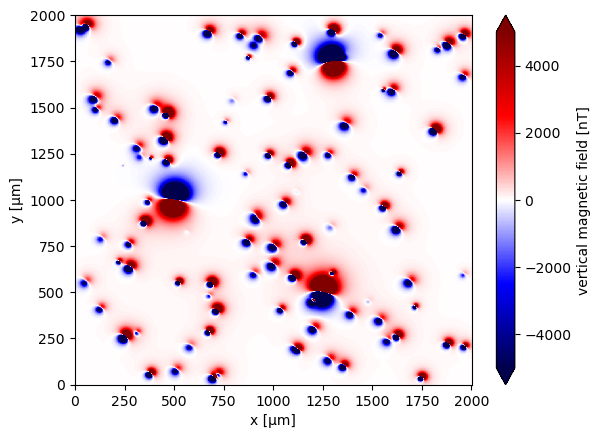

In [3]:
data.plot.pcolormesh(cmap="seismic", vmin=-5000, vmax=5000)

In [4]:
def horizontal_derivatives(data):
    """
    Compute first-order spatial derivatives in the x and y directions.

    Parameters
    ----------
    data : xr.DataArray
        Input data array with coordinates "x" and "y".

    Returns
    -------
    dx : xr.DataArray
        First derivative along the x-direction.
    dy : xr.DataArray
        First derivative along the y-direction.
    """
    dx = hm.derivative_easting(data)
    dy = hm.derivative_northing(data)
    return dx, dy

In [5]:
def estimate_grid_spacing(data):
    """
    Estimate grid spacing as the mean difference in x and y coordinates.

    Parameters
    ----------
    data : xr.DataArray
        Input data array with coordinates "x" and "y".

    Returns
    -------
    spacing : float
        Estimated grid spacing.
    """
    return np.mean([np.abs(data.x[1] - data.x[0]), np.abs(data.y[1] - data.y[0])])

In [6]:
def vertical_derivative(data, spacing):
    """
    Compute the first-order vertical derivative using finite differences.

    The vertical derivative is estimated using the difference between an
    upward-continued and a downward-continued version of the data. This avoids
    downward continuation, which can amplify noise.

    Parameters
    ----------
    data : xr.DataArray
        Input data array.
    spacing : float
        Grid spacing used for upward and downward continuation.

    Returns
    -------
    dz : xr.DataArray
        First derivative along the z-direction.
    """
    data_up = hm.upward_continuation(data, spacing).assign_coords(x=data.x, y=data.y)
    data_down = hm.upward_continuation(data, -spacing).assign_coords(x=data.x, y=data.y)
    return (data_up - data_down) / (2 * spacing)

In [7]:
def total_gradient_amplitude(dx, dy, dz) -> xr.DataArray:
    """
    Compute the total gradient amplitude from spatial derivatives.

    Parameters
    ----------
    dx : xr.DataArray
        First derivative along the x-direction.
    dy : xr.DataArray
        First derivative along the y-direction.
    dz : xr.DataArray
        First derivative along the z-direction.

    Returns
    -------
    tga : xr.DataArray
        Total gradient amplitude.
    """
    return np.sqrt(dx**2 + dy**2 + dz**2)

In [8]:
dx, dy = horizontal_derivatives(data)

In [9]:
spacing = estimate_grid_spacing(data)

In [10]:
dz = vertical_derivative(data, spacing)

/home/yago/miniforge3/envs/magali/lib/python3.12/site-packages/xrft/xrft.py:573: FutureWarning: Default ifft's behaviour (lag=None) changed! Default value of lag was zero (centered output coordinates) and is now set to transformed coordinate's attribute: 'direct_lag'.
  warnings.warn(msg, FutureWarning)
/home/yago/miniforge3/envs/magali/lib/python3.12/site-packages/xrft/xrft.py:573: FutureWarning: Default ifft's behaviour (lag=None) changed! Default value of lag was zero (centered output coordinates) and is now set to transformed coordinate's attribute: 'direct_lag'.
  warnings.warn(msg, FutureWarning)


In [11]:
tga = total_gradient_amplitude(dx, dy, dz)

In [12]:
data

<xarray.DataArray 'bz' (y: 1001, x: 1001)> Size: 8MB
array([[  5.75579178,   5.80235792,   5.84941598, ...,  11.20841375,
         11.08121811,  10.95627822],
       [  5.79476683,   5.84187452,   5.88948247, ...,  11.32989443,
         11.20112229,  11.07462351],
       [  5.83404969,   5.88170584,   5.92987074, ...,  11.45346706,
         11.32310771,  11.195038  ],
       ...,
       [353.39773091, 375.79989349, 399.42908346, ...,  80.46141253,
         79.04504462,  77.5925126 ],
       [338.14056768, 358.80973759, 380.55188685, ...,  76.55781378,
         75.25274995,  73.91367197],
       [323.29237756, 342.35442734, 362.35356693, ...,  72.90986035,
         71.70538717,  70.46895364]])
Coordinates:
  * x        (x) float64 8kB 0.0 2.0 4.0 6.0 ... 1.996e+03 1.998e+03 2e+03
  * y        (y) float64 8kB 0.0 2.0 4.0 6.0 ... 1.996e+03 1.998e+03 2e+03
    z        (y, x) float64 8MB 5.0 5.0 5.0 5.0 5.0 5.0 ... 5.0 5.0 5.0 5.0 5.0
Attributes:
    long_name:  vertical magnetic field
    units:      nT

In [13]:
def total_gradient_amplitude_grid(data):
    """
    Compute the total gradient amplitude (TGA) of a given data array.

    The function calculates the horizontal and vertical derivatives of the input data and then
    computes the total gradient amplitude.

    Parameters
    ----------
    data : xr.DataArray
        Input data array with coordinates `x` and `y`.

    Returns
    -------
    tga : xr.DataArray
        Dataset containing the total gradient amplitude (TGA).
    """
    dx, dy = horizontal_derivatives(data)
    spacing = estimate_grid_spacing(data)
    dz = vertical_derivative(data, spacing)
    tga = total_gradient_amplitude(dx, dy, dz)

    # Assign attributes
    tga.attrs = {"long_name": "Total Gradient Amplitude", "units": "nT/µm"}

    return tga

In [14]:
data_tga = total_gradient_amplitude_grid(data)
data_tga

/home/yago/miniforge3/envs/magali/lib/python3.12/site-packages/xrft/xrft.py:573: FutureWarning: Default ifft's behaviour (lag=None) changed! Default value of lag was zero (centered output coordinates) and is now set to transformed coordinate's attribute: 'direct_lag'.
  warnings.warn(msg, FutureWarning)
/home/yago/miniforge3/envs/magali/lib/python3.12/site-packages/xrft/xrft.py:573: FutureWarning: Default ifft's behaviour (lag=None) changed! Default value of lag was zero (centered output coordinates) and is now set to transformed coordinate's attribute: 'direct_lag'.
  warnings.warn(msg, FutureWarning)


<xarray.DataArray (y: 1001, x: 1001)> Size: 8MB
array([[3.08280851e+02, 2.61115640e+02, 3.04493056e+02, ...,
        5.38889112e+01, 8.15593537e+01, 1.71255830e+01],
       [6.49943206e+01, 5.11164359e+01, 5.75124979e+01, ...,
        9.19829353e-02, 2.56132010e+00, 1.65758799e+01],
       [6.41640132e+01, 5.43224557e+01, 6.34469449e+01, ...,
        1.57425772e+01, 2.19734392e+01, 9.27341842e+00],
       ...,
       [2.66930682e+02, 1.46600178e+01, 1.00363164e+02, ...,
        3.70593089e+01, 5.64007558e+01, 2.25561034e+02],
       [1.30189990e+02, 1.01704021e+02, 2.77011012e+01, ...,
        5.14356632e+01, 2.96215634e+01, 2.09928078e+02],
       [4.84241625e+02, 2.03742212e+02, 3.25147553e+02, ...,
        2.56093606e+00, 1.08401859e+02, 2.01968876e+02]])
Coordinates:
  * x        (x) float64 8kB 0.0 2.0 4.0 6.0 ... 1.996e+03 1.998e+03 2e+03
  * y        (y) float64 8kB 0.0 2.0 4.0 6.0 ... 1.996e+03 1.998e+03 2e+03
    z        (y, x) float64 8MB 5.0 5.0 5.0 5.0 5.0 5.0 ... 5.0 5.0 5.0 5.0 5.0
Attributes:
    long_name:  Total Gradient Amplitude
    units:      nT/µm

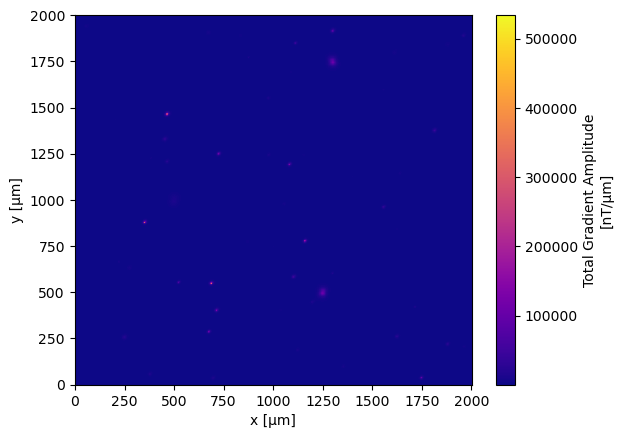

In [15]:
data_tga.plot.pcolormesh(cmap="plasma")